# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
from google.colab import files
import os

# Prompt the user to upload a file
uploaded = files.upload()

!ls -ltr

Saving AMZN_stocks_data.csv to AMZN_stocks_data.csv
Saving GOOGL_stocks_data.csv to GOOGL_stocks_data.csv
Saving IBM_stocks_data.csv to IBM_stocks_data.csv
Saving MSFT_stocks_data.csv to MSFT_stocks_data.csv
total 616
drwxr-xr-x 1 root root   4096 May 29 14:01 sample_data
-rw-r--r-- 1 root root 149472 Jun  2 16:16 MSFT_stocks_data.csv
-rw-r--r-- 1 root root 153466 Jun  2 16:16 IBM_stocks_data.csv
-rw-r--r-- 1 root root 161692 Jun  2 16:16 GOOGL_stocks_data.csv
-rw-r--r-- 1 root root 154394 Jun  2 16:16 AMZN_stocks_data.csv


In [3]:
# Define a function to load data and aggregate them
def load_and_aggregate_stock_data(files):
    # Initialize an empty list to hold the DataFrames
    stock_data_frames = []

    for file in files:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file)

        # Check if 'Name' column exists and it's filled with the company name
        stock_name = df['Name'].iloc[0]  # Extract stock name from the 'Name' column

        # Ensure that the 'Date' column is parsed as datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Append the DataFrame to the list
        stock_data_frames.append(df)

    # Concatenate all DataFrames into a single DataFrame
    aggregated_data = pd.concat(stock_data_frames, ignore_index=True)

    # Optionally, sort the data by date (if needed)
    aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'])
    aggregated_data.sort_values(['Name', 'Date'], inplace=True)


    return aggregated_data


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
# List of file paths (these should be the paths where the files are stored)
files = [
    'GOOGL_stocks_data.csv',  # Replace with actual file paths
    'AMZN_stocks_data.csv',
    'MSFT_stocks_data.csv',
    'IBM_stocks_data.csv'
]

# Call the function to load and aggregate the data
aggregated_df = load_and_aggregate_stock_data(files)


In [5]:
# View specifics of the data
print(aggregated_df.head())
print(aggregated_df.shape)
print(aggregated_df.info())

           Date   Open   High    Low  Close   Volume  Name
3019 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
3020 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
3021 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3022 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
3023 2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
(12077, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 12077 entries, 3019 to 9056
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12077 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12077 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12077 non-null  float64       
 5   Volume  12077 non-null  int64         
 6   Name    12077 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB
None


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [6]:
# Handle Missing Values
print(aggregated_df.isnull().sum())
aggregated_df.dropna(subset=['Open', 'Low'], inplace=True)
print(aggregated_df.shape)


Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
(12076, 7)


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

count    1.207600e+04
mean     1.671865e+07
std      2.570653e+07
min      2.542560e+05
25%      3.124251e+06
50%      5.445861e+06
75%      1.802312e+07
max      5.910786e+08
Name: Volume, dtype: float64
Frequency distribution of binned Volume:
Volume_Binned
(0.0, 5000000.0]            5583
(5000000.0, 10000000.0]     2798
(30000000.0, inf]           2351
(10000000.0, 15000000.0]     524
(20000000.0, 25000000.0]     285
(15000000.0, 20000000.0]     268
(25000000.0, 30000000.0]     267
Name: count, dtype: int64


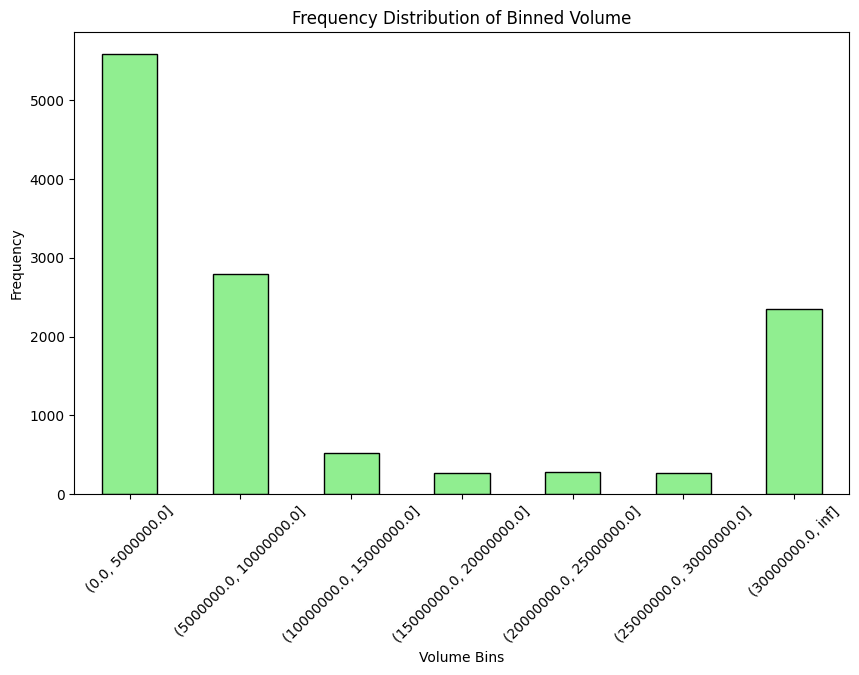

In [7]:
# Frequency distribution of volumes
import pandas as pd
import matplotlib.pyplot as plt
print(aggregated_df['Volume'].describe())
# Binning the 'Volume' column into intervals
bins = [0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, float('inf')]
aggregated_df['Volume_Binned'] = pd.cut(aggregated_df['Volume'], bins)

# Frequency distribution of binned volume
volume_binned_distribution = aggregated_df['Volume_Binned'].value_counts()

# Print the frequency distribution
print("Frequency distribution of binned Volume:")
print(volume_binned_distribution)

# Plotting the frequency distribution of binned volumes
plt.figure(figsize=(10, 6))
volume_binned_distribution.sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution of Binned Volume')
plt.xlabel('Volume Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


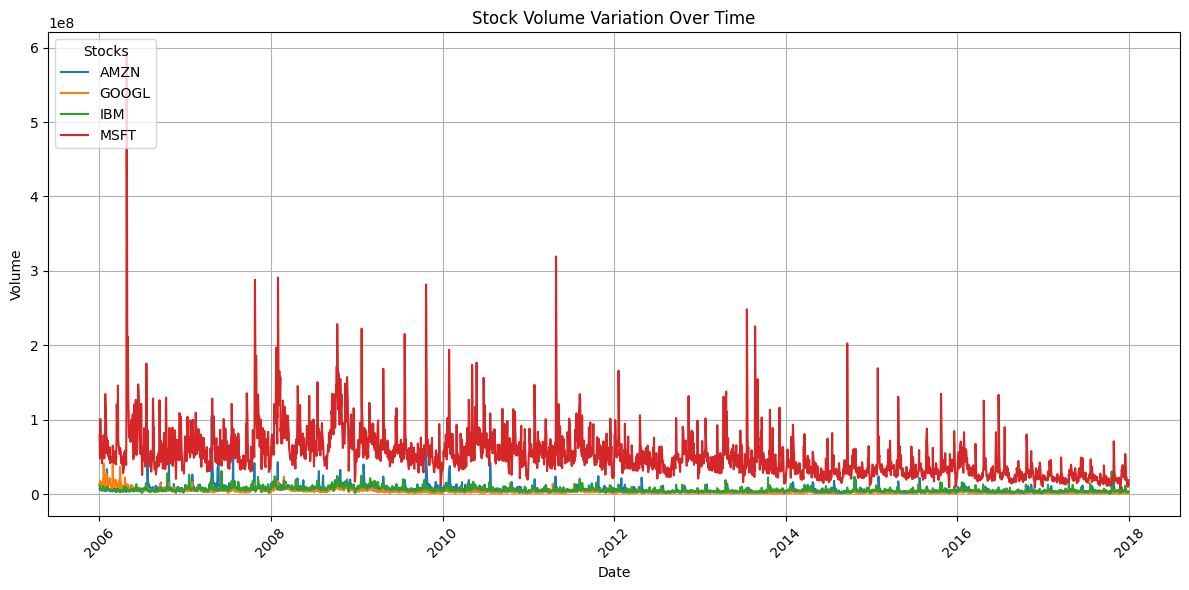

In [8]:
# Stock volume variation over time
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'])

# Plot the stock volume variation over time
plt.figure(figsize=(12, 6))

# Plot the volume variation for each stock (using 'Name' to separate by stock symbol)
for stock_name in aggregated_df['Name'].unique():
    stock_data = aggregated_df[aggregated_df['Name'] == stock_name]
    plt.plot(stock_data['Date'], stock_data['Volume'], label=stock_name)

# Add labels and title
plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title="Stocks", loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

Correlation Matrix:
            Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420741
High    0.999945  1.000000  0.999907  0.999935 -0.421103
Low     0.999919  0.999907  1.000000  0.999945 -0.420673
Close   0.999873  0.999935  0.999945  1.000000 -0.420895
Volume -0.420741 -0.421103 -0.420673 -0.420895  1.000000


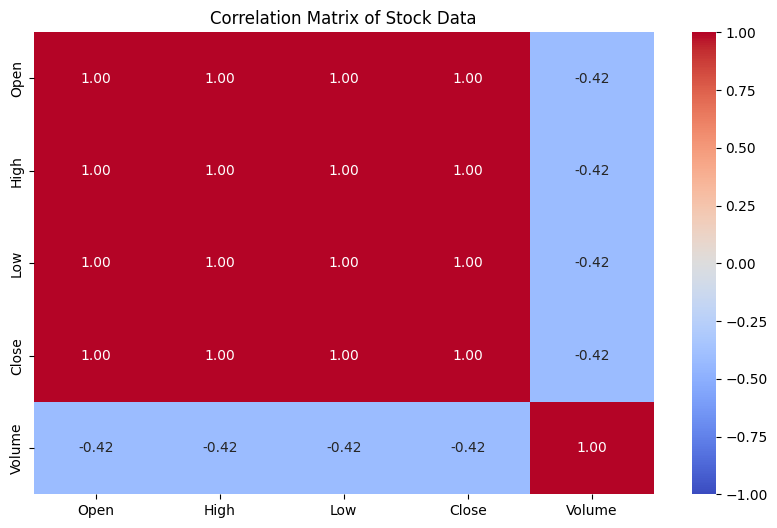

In [9]:
# Analyse correlations
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for numerical columns
correlation_matrix = aggregated_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Data')
plt.show()



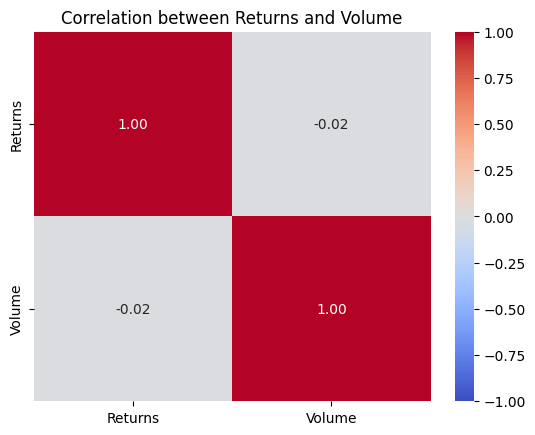

           Date   Open   High    Low  Close   Volume  Name
3019 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
3020 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
3021 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3022 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
3023 2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN


In [10]:
# Calculate daily returns (percentage change)
aggregated_df['Returns'] = aggregated_df['Close'].pct_change()

# Calculate the correlation of Returns with Volume
returns_volume_correlation = aggregated_df[['Returns', 'Volume']].corr()

# Plot the correlation matrix for Returns and Volume
sns.heatmap(returns_volume_correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between Returns and Volume')
plt.show()
aggregated_df.drop(columns=['Volume_Binned', 'Returns'], inplace=True)
# Verify that the columns were dropped
print(aggregated_df.head())

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [11]:
import pandas as pd

def create_windowed_data(df, window_size, encoder, features_to_scale):
    X, y = [], []
    for name in df['Name'].unique():
        company_df = df[df['Name'] == name]
        scaled_features = company_df[[f + '_Scaled' for f in features_to_scale]].values
        company_features = company_df[encoder.get_feature_names_out(['Name'])].values
        for i in range(window_size, len(scaled_features)):
            seq_features = scaled_features[i - window_size:i]
            seq_company = np.repeat(company_features[i].reshape(1, -1), window_size, axis=0)
            seq = np.hstack([seq_features, seq_company])
            X.append(seq)
            y.append(scaled_features[i][features_to_scale.index('Close')])
    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [12]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_and_encode(df, features_to_scale):
    scalers = {}
    for name in df['Name'].unique():
        scaler = MinMaxScaler()
        idx = df['Name'] == name
        df.loc[idx, [f + '_Scaled' for f in features_to_scale]] = scaler.fit_transform(df.loc[idx, features_to_scale])
        scalers[name] = scaler
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[['Name']])
    df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Name']))
    df = pd.concat([df.reset_index(drop=True), df_encoded], axis=1)
    return df, encoder, scalers


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [13]:
# Define a function to create input and output data points from the master DataFrame
def create_train_val_data(df, target_names, window_size, split_ratio, features_to_scale):
    df = df[df['Name'].isin(target_names)]
    df, encoder, scalers = scale_and_encode(df, features_to_scale)
    X, y = create_windowed_data(df, window_size, encoder, features_to_scale)
    nan_mask = ~np.isnan(X).any(axis=(1, 2))
    X, y = X[nan_mask], y[nan_mask]
    split = int(split_ratio * len(X))
    return X[:split], X[split:], y[:split], y[split:], encoder

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

<ipython-input-14-2fcb67d00e49>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format


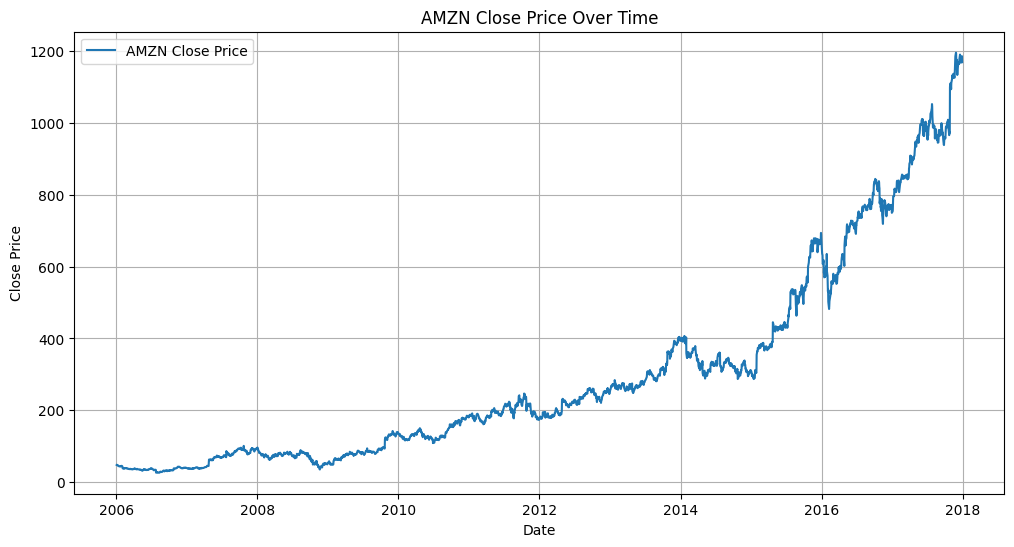

<ipython-input-14-2fcb67d00e49>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format
<ipython-input-14-2fcb67d00e49>:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  stock_data_quarterly = stock_data.resample('Q', on='Date').last()  # 'Q' gives quarterly resampling


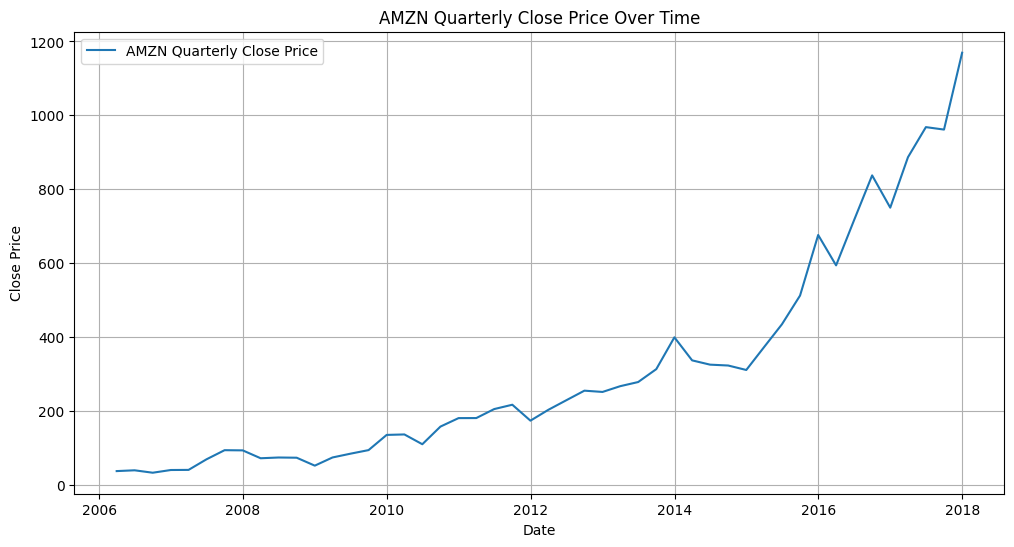

<ipython-input-14-2fcb67d00e49>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format


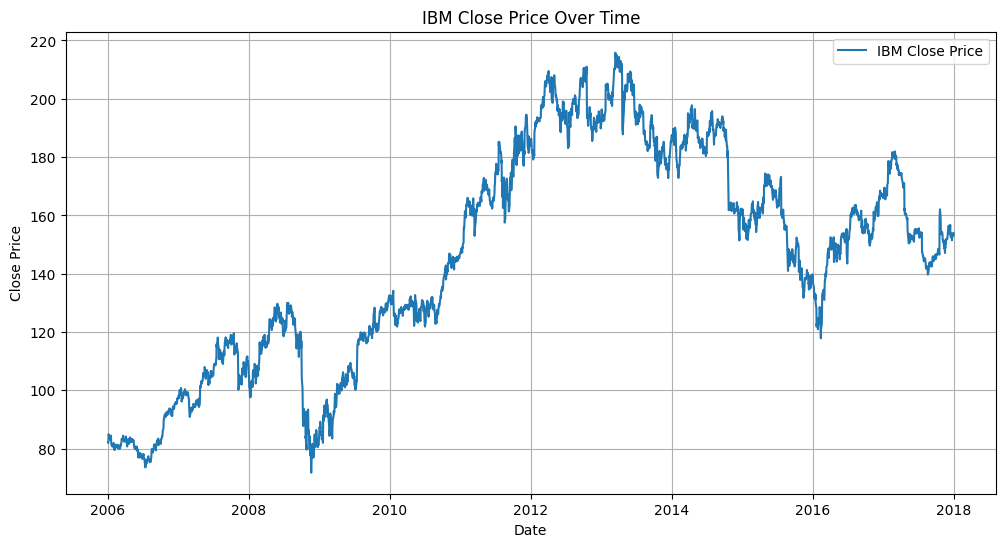

<ipython-input-14-2fcb67d00e49>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format


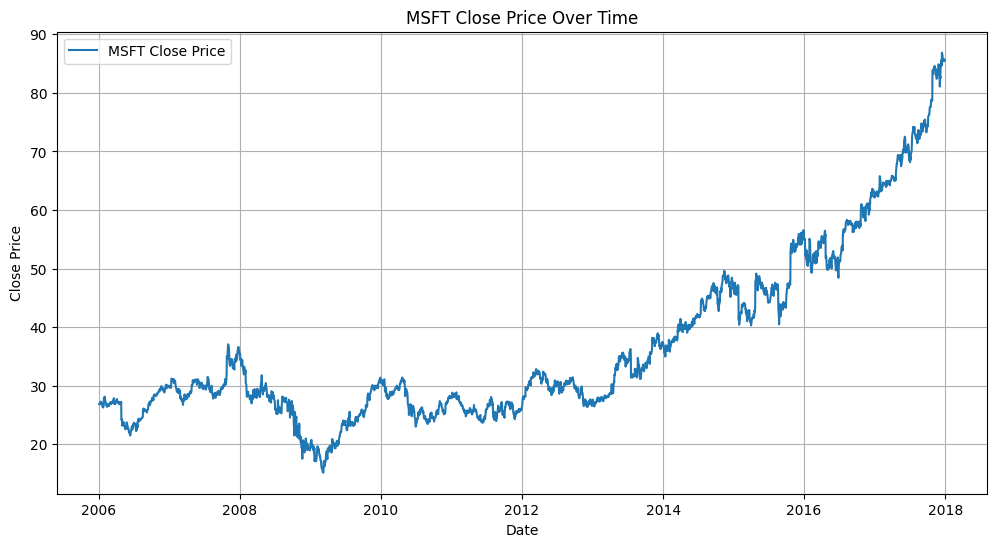

In [14]:
# Checking for patterns in different sequence lengths
import matplotlib.pyplot as plt
import pandas as pd

def plot_close_price(df, stock_name):
    """
    Plot the Close price of a specific stock over time.

    Parameters:
    df (pd.DataFrame): The stock market DataFrame with columns like Date, Close, Name.
    stock_name (str): The name of the stock to plot (e.g., 'GOOGL', 'AAPL').

    Returns:
    None: Displays the plot.
    """
    # Filter data for the specified stock
    stock_data = df[df['Name'] == stock_name]
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format
    stock_data = stock_data.sort_values('Date')

    # Plot Close price over time
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label=f'{stock_name} Close Price')
    plt.title(f'{stock_name} Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_quarterly_close_price(df, stock_name):
    """
    Plot the quarterly Close price of a specific stock over time.

    Parameters:
    df (pd.DataFrame): The stock market DataFrame with columns like Date, Close, Name.
    stock_name (str): The name of the stock to plot (e.g., 'GOOGL', 'AAPL').

    Returns:
    None: Displays the plot.
    """
    # Filter data for the specified stock
    stock_data = df[df['Name'] == stock_name]
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure Date is in datetime format
    stock_data = stock_data.sort_values('Date')

    # Resample the data to quarterly frequency, using the last close price of each quarter
    stock_data_quarterly = stock_data.resample('Q', on='Date').last()  # 'Q' gives quarterly resampling

    # Plot Close price over time (quarterly)
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data_quarterly.index, stock_data_quarterly['Close'], label=f'{stock_name} Quarterly Close Price')
    plt.title(f'{stock_name} Quarterly Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: Plotting for GOOGL
plot_close_price(aggregated_df, 'AMZN')
plot_quarterly_close_price(aggregated_df, 'AMZN')
plot_close_price(aggregated_df, 'IBM')
plot_close_price(aggregated_df, 'MSFT')




#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [15]:
# Create data instances from the master data frame using decided window size and window stride
df_all = load_and_aggregate_stock_data(files)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target_stocks =  ["AMZN","GOOGL","IBM","MSFT"]
X_train, X_test, y_train, y_test, encoder = create_train_val_data(df_all, target_stocks, window_size=65, split_ratio=0.8, features_to_scale=features)


In [16]:
# Check the number of data points generated
print("Training Features (X_train) shape:", X_train.shape)
print("Training Targets (y_train) shape:", y_train.shape)
print("Validation Features (X_val) shape:", X_test.shape)
print("Validation Targets (y_val) shape:", y_test.shape)

Training Features (X_train) shape: (9401, 65, 9)
Training Targets (y_train) shape: (9401,)
Validation Features (X_val) shape: (2351, 65, 9)
Validation Targets (y_val) shape: (2351,)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [17]:
# Check if the datasets are compatible inputs to neural networks
import numpy as np

def check_data_format(X_train, y_train, X_val, y_val):
    """
    Check if the datasets are in the correct format for neural networks.

    Parameters:
    X_train (np.array): The training features (input data).
    y_train (np.array): The training target values.
    X_val (np.array): The validation features.
    y_val (np.array): The validation target values.

    Returns:
    None: Prints out whether the datasets are in the correct format.
    """

    # Check the shape of the training and validation feature matrices (X)
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_val:", X_val.shape)

    # Check if X_train and X_val are 3D arrays (for time series data)
    if len(X_train.shape) != 3 or len(X_val.shape) != 3:
        print("Error: X_train and X_val must be 3D arrays with shape (num_samples, timesteps, num_features).")
    else:
        print("X_train and X_val have the correct shape for sequential data.")

    # Check the shape of the target variables (y)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_val:", y_val.shape)

    # Check if y_train and y_val are 1D arrays (since this is a regression problem)
    if len(y_train.shape) != 1 or len(y_val.shape) != 1:
        print("Error: y_train and y_val must be 1D arrays with shape (num_samples,).")
    else:
        print("y_train and y_val have the correct shape for regression.")

    # Check if the data types are appropriate (i.e., floats for neural networks)
    if not np.issubdtype(X_train.dtype, np.floating) or not np.issubdtype(X_val.dtype, np.floating):
        print("Error: X_train and X_val should contain floating-point values.")
    else:
        print("X_train and X_val have the correct data type (float).")

    if not np.issubdtype(y_train.dtype, np.floating) or not np.issubdtype(y_val.dtype, np.floating):
        print("Error: y_train and y_val should contain floating-point values.")
    else:
        print("y_train and y_val have the correct data type (float).")

# Check the format of the training and validation sets
check_data_format(X_train, y_train, X_test, y_test)


Shape of X_train: (9401, 65, 9)
Shape of X_val: (2351, 65, 9)
X_train and X_val have the correct shape for sequential data.
Shape of y_train: (9401,)
Shape of y_val: (2351,)
y_train and y_val have the correct shape for regression.
X_train and X_val have the correct data type (float).
y_train and y_val have the correct data type (float).


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [18]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_rnn_model(input_shape, units=50, dropout_rate=0.5, learning_rate=0.0001, return_sequences=False):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation='relu', input_shape=input_shape, return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [19]:
# Find an optimal configuration of simple RNN
df_all = load_and_aggregate_stock_data(files)
target_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X_train, X_test, y_train, y_test, encoder = create_train_val_data(df_all, target_stocks, window_size=65, split_ratio=0.8, features_to_scale=features)

model = create_rnn_model(X_train.shape[1:], units=70, dropout_rate=0.3, learning_rate=0.001)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


model = create_rnn_model(X_train.shape[1:], units=60, dropout_rate=0.3, learning_rate=0.0005)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


model = create_rnn_model(X_train.shape[1:], units=50, dropout_rate=0.5, learning_rate=0.0005)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


model = create_rnn_model(X_train.shape[1:], units=50, dropout_rate=0.3, learning_rate=0.001)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 70)             │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,671 (22.15 KB)

 Trainable params: 5,671 (22.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0409 - val_loss: 0.0037
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0021 - val_loss: 0.0032
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
R² Score: 0.9633
MSE: 0.001794


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 60)             │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,261 (16.64 KB)

 Trainable params: 4,261 (16.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0759 - val_loss: 8.0840e-04
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075 - val_loss: 4.4549e-04
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0036 - val_loss: 7.3986e-04
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0029 - val_loss: 4.6928e-04
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
R² Score: 0.9909
MSE: 0.000445


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051 (11.92 KB)

 Trainable params: 3,051 (11.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0492 - val_loss: 0.0025
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097 - val_loss: 0.0025
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - val_loss: 0.0034
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
R² Score: 0.9490
MSE: 0.002491


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051 (11.92 KB)

 Trainable params: 3,051 (11.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0265 - val_loss: 0.0097
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 10/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0021 - val_loss: 0.0022
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
R² Score: 0.9545
MSE: 0.002222


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [20]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

model = create_rnn_model(X_train.shape[1:], units=50, dropout_rate=0.3, learning_rate=0.001)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50)             │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051 (11.92 KB)

 Trainable params: 3,051 (11.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0238 - val_loss: 5.6763e-04
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0046 - val_loss: 4.3702e-04
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025 - val_loss: 5.6693e-04


Plotting the actual vs predicted values

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


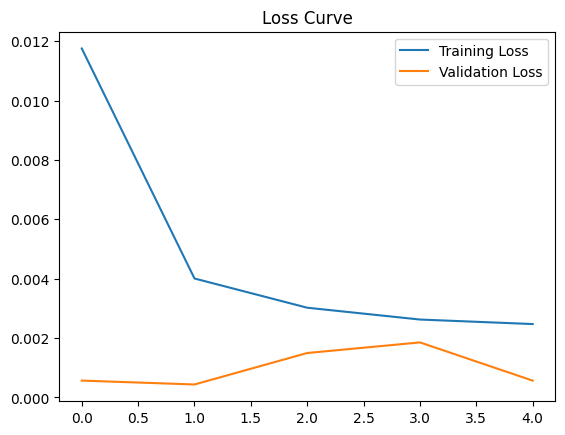

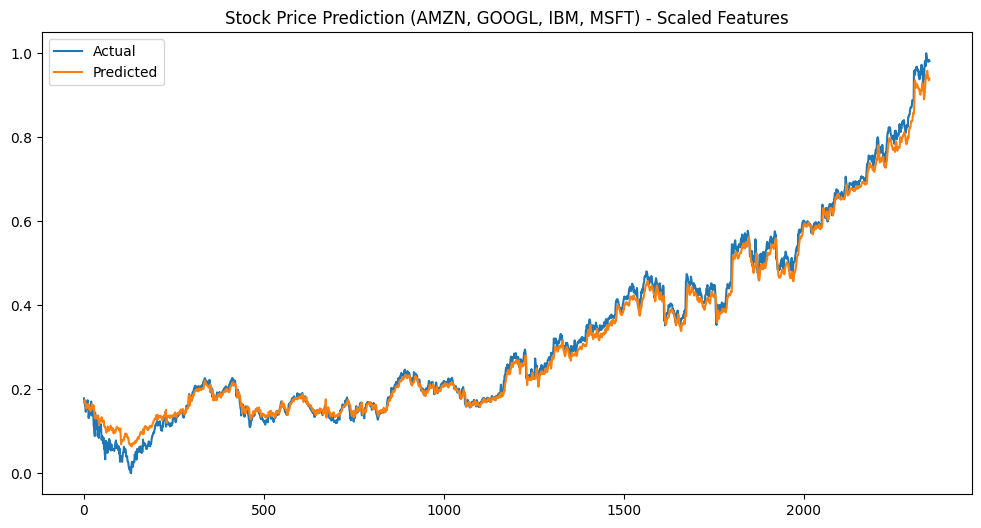

In [21]:
# Predict on the test data and plot

def plot_predictions(y_test, y_pred, loss_history, title):
    plt.plot(loss_history['loss'], label='Training Loss')
    plt.plot(loss_history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

y_pred = model.predict(X_test)
plot_predictions(y_test, y_pred, history.history, f"Stock Price Prediction ({', '.join(target_stocks)}) - Scaled Features")

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [22]:
# Compute the performance of the model on the testing data set
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


R² Score: 0.9911
MSE: 0.000437


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [23]:
# # Define a function to create a model and specify default values for hyperparameters
from tensorflow.keras.layers import LSTM, Dense, Dropout
def create_lstm_model(input_shape, units=50, dropout_rate=0.5, learning_rate=0.0001):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [24]:
# Find an optimal configuration
lstm_model = create_lstm_model(X_train.shape[1:], units=50, dropout_rate=0.3, learning_rate=0.001)
lstm_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = lstm_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


lstm_model = create_lstm_model(X_train.shape[1:], units=60, dropout_rate=0.5, learning_rate=0.001)
lstm_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = lstm_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")

lstm_model = create_lstm_model(X_train.shape[1:], units=70, dropout_rate=0.5, learning_rate=0.001)
lstm_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = lstm_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")

lstm_model = create_lstm_model(X_train.shape[1:], units=40, dropout_rate=0.5, learning_rate=0.001)
lstm_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])
y_pred = lstm_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,051 (47.07 KB)

 Trainable params: 12,051 (47.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0431 - val_loss: 0.0021
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - val_loss: 7.1113e-04
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022 - val_loss: 4.7853e-04
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022 - val_loss: 7.2589e-04
Epoch 9/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022 - val_loss: 3.3943e-04
Epoch 10/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0020 - val_loss: 5.5827e-04
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
R² Score: 0.9931
MSE: 0.000339


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60)             │        16,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,861 (65.86 KB)

 Trainable params: 16,861 (65.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0237 - val_loss: 0.0110
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 9/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0034 - val_loss: 0.0010
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
R² Score: 0.9789
MSE: 0.001030


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 70)             │        22,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,471 (87.78 KB)

 Trainable params: 22,471 (87.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0183 - val_loss: 0.0020
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038 - val_loss: 5.7885e-04
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0034 - val_loss: 9.4554e-04
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 4.9459e-04
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031 - val_loss: 6.0920e-04
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033 - val_loss: 0.0016
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
R² Score: 0.9899
MSE: 0.000495


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 40)             │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,041 (31.41 KB)

 Trainable params: 8,041 (31.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0239 - val_loss: 0.0015
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0035
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
R² Score: 0.9684
MSE: 0.001543


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [25]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
lstm_model = create_lstm_model(X_train.shape[1:], units=50, dropout_rate=0.3, learning_rate=0.001)
lstm_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,051 (47.07 KB)

 Trainable params: 12,051 (47.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0151 - val_loss: 0.0074
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0023 - val_loss: 5.2304e-04
Epoch 9/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0024 - val_loss: 8.7266e-04
Epoch 10/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0025 - val_loss: 8.4934e-04


In [26]:
# Compute the performance of the model on the testing data set
y_pred = lstm_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
R² Score: 0.9893
MSE: 0.000523


Plotting the actual vs predicted values

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


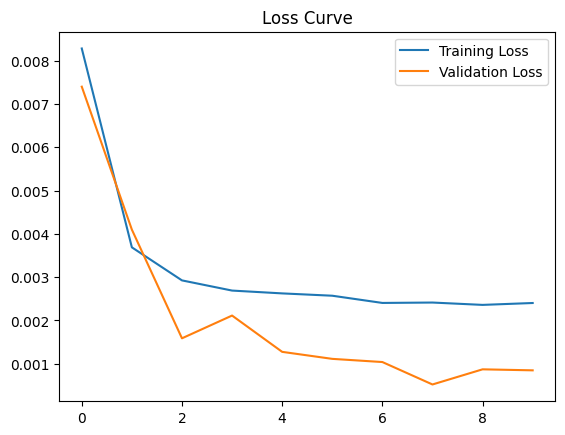

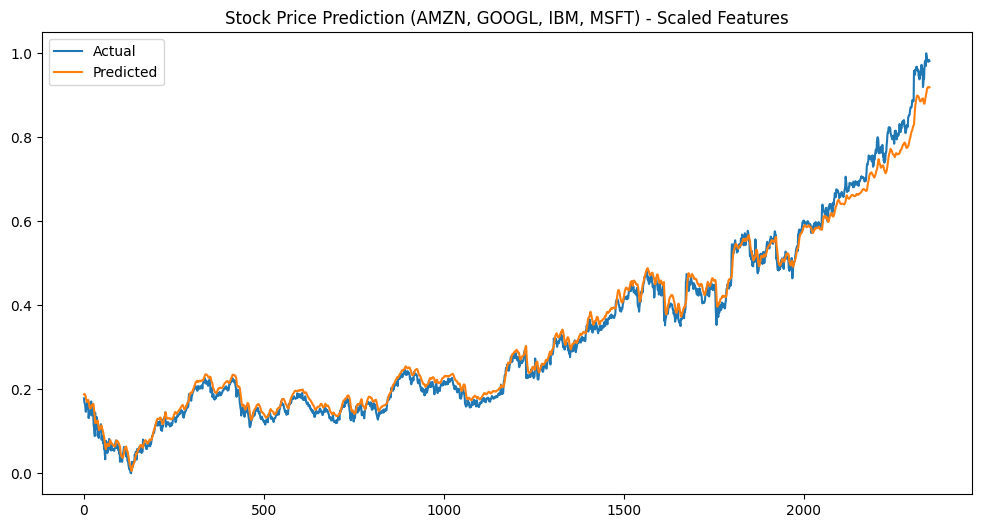

In [27]:
# Predict on the test data
y_pred = lstm_model.predict(X_test)
plot_predictions(y_test, y_pred, history.history, f"Stock Price Prediction ({', '.join(target_stocks)}) - Scaled Features")

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [28]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [29]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [30]:
# Find an optimal configuration of simple RNN



In [31]:
# Find the best configuration



In [32]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [33]:
# Compute the performance of the model on the testing data set



In [34]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [35]:
# Find an optimal configuration of advanced RNN



In [36]:
# Find the best configuration



In [37]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [38]:
# Compute the performance of the model on the testing data set



In [39]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## Conclusion

1. The aggregated dataframe had **one Null record**, which was **removed**

2. The values **Open**, **High**, **Low**, and **Close** are **significantly correlated** with one another.

3. A **window size of 60** was identified as **ideal** for time-series modeling.

4. **Simple RNN** was evaluated with various hyperparameters. The test accuracies obtained were:
   - 0.96  
   - 0.99  
   - 0.94  
   - 0.95  

   The **optimal hyperparameters** chosen were:  
   `units = 50`, `dropout_rate = 0.3`, `learning_rate = 0.001`


                                                       
5. **LSTM RNN** was evaluated with various hyperparameters. The test accuracies obtained were:
   - 0.99  
   - 0.97  
   - 0.98  
   - 0.96  

   The **optimal hyperparameters** chosen were:  
   `units = 50`, `dropout_rate = 0.3`, `learning_rate = 0.001`
   ──────┘

                                                       